# Tag Classification Model v2

Author: 
* Luis Henrique M O Imagiire

Status: 
* Done

Goal:
* This is a clearer developement from tagclassificationmodel notebook. Here we extend the first notebook by simplifying our model range (multiclassification -> binary) and using word position signal to increase model performance. 

In [1]:
%cd ..

/home/luis/ds4a/notebooks


## Loading and preprocessing

In [5]:
from src.loading import load_dataset
from src.cleaning import build_df_from_RA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import unicodedata

# Load dataFrame
df = build_df_from_RA(load_dataset("dataset"))
print(f"We have a total of {df.shape[0]} reviews!")

We have a total of 51655 reviews!


In [6]:
from gensim.test.utils import get_tmpfile
from pathlib import Path
from gensim.models.fasttext import FastText

# Load model
model = FastText.load(get_tmpfile(str(Path().cwd() / "fasttext.model")))

In [9]:
from src.model_inference import get_text_feature_df

# Get feature df
feat_df = get_text_feature_df(df, model)
feat_df.head()

/home/luis/ds4a/notebooks/src/model_inference.py:9: RuntimeWarning: Mean of empty slice.
  try:
/home/luis/anaconda3/envs/un_cuda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95,feat_96,feat_97,feat_98,feat_99
0,0.910237,0.948026,-0.580685,-1.087124,0.408073,0.035028,-0.255468,0.727001,0.511160,0.465338,...,0.225110,-0.556976,-0.199568,-0.029514,-0.384443,0.634457,-1.426050,-1.708523,0.028207,0.248345
1,-0.006765,0.400626,-0.188688,-2.611415,0.161582,1.001012,-1.393652,0.024986,-0.286601,0.050815,...,0.643617,-0.681656,-2.090754,0.766479,-0.360157,-0.899276,-0.045452,-1.029047,-0.453788,0.370695
2,-0.295514,-0.242192,-1.230961,-2.276299,-0.154886,0.099664,-1.411958,-0.046187,-0.566358,-0.810014,...,0.156349,-0.403661,-1.800049,0.152794,0.364936,-0.128633,-0.469290,-1.516815,0.014385,0.350531
3,0.538521,-0.414169,-0.821009,-2.062811,-1.239713,0.311726,-0.904301,0.296257,0.148219,-1.170139,...,0.397926,-1.703135,-2.093588,0.467810,0.270992,-1.369555,-0.121953,-1.803416,0.848096,1.088491
4,0.502684,0.101890,-0.161741,-2.076119,-0.018616,0.181313,-1.878871,-0.759554,-0.606767,-1.163182,...,0.418289,-1.644738,-2.112830,1.213724,0.711859,-0.254544,-1.367691,-1.562384,-0.460997,0.439617


In [38]:
# Pre-load tag columns
product_issues_columns = ['product_issues_Quality','product_issues_Damaged', 'product_issues_Electrical problems','product_issues_Missing pieces']
business_issues_columns = ['business_issues_Payment','business_issues_Maintenance', 'business_issues_Customer Services','business_issues_Delivery', 'business_issues_Online Services']
tag_columns = product_issues_columns.copy()
tag_columns.extend(business_issues_columns)

# Create product/business issue tag and drop those who have both tagged to simplify our analysis
df_tag = df[tag_columns].fillna(0).applymap(lambda x: 1 if x>0 else 0)
df_tag["product_issue"] = df_tag[product_issues_columns].max(axis=1)
df_tag["business_issue"] = df_tag[business_issues_columns].max(axis=1)
df_tag = df_tag[df_tag[["product_issue", "business_issue"]].sum(axis=1) != 2]
df_tag = df_tag[df_tag[["product_issue", "business_issue"]].sum(axis=1) != 0]

df_tag = df_tag.loc[df_tag.index.intersection(feat_df.index)] # match index from feature df 
df_tag.head()

,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,product_issue,business_issue
0,1,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,1,0,0,1
2,1,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,1,0,1
5,1,0,0,0,0,0,0,0,0,1,0


In [42]:
from sklearn.model_selection import train_test_split

X = feat_df.loc[feat_df.index.intersection(df_tag.index)]
Y = df_tag

X_test = X.iloc[-100::]
Y_test = Y.iloc[-100::]

X_t = X.iloc[0:-100]
Y_t = Y.iloc[0:-100]

# Sanity check
assert X_test.shape[0] + X_t.shape[0] == X.shape[0]
assert Y_test.shape[0] + Y_t.shape[0] == Y.shape[0]

seed = 2020
split = 0.95  # We have a bunch of data
X_train, X_validation, y_train, y_validation = train_test_split(X_t, Y_t, train_size=split, random_state=seed)

In [40]:
y_train.head()

,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,product_issue,business_issue
23095,0,1,0,0,0,0,0,0,0,1,0
42575,0,0,0,0,1,0,0,0,0,0,1
16495,0,0,0,0,0,0,1,0,0,0,1
14998,0,1,0,0,0,0,0,0,0,1,0
28939,0,0,0,0,0,0,0,1,0,0,1


## Training the model

In [35]:
import tensorflow as tf
from tensorflow.keras import layers
tf.config.experimental.list_physical_devices('GPU')

/home/luis/anaconda3/envs/un_cuda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/luis/anaconda3/envs/un_cuda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/luis/anaconda3/envs/un_cuda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/luis/anaconda3/envs/un_cuda/lib/python3.7/s

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Pre-loading
filepath="weights-improvement-BinaryModel-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

embedding_dim = 100
batch_size = 128
epochs = 40
stack = 6


def create_network(n_dense=6,
                   dense_units=16,
                   activation='selu',
                   dropout=layers.Dropout,
                   dropout_rate=0.1,
                   kernel_initializer='lecun_normal',
                   optimizer='adam',
                   num_classes=1,
                   max_words=embedding_dim):
    
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(dense_units, input_shape=(max_words,),
                    kernel_initializer=kernel_initializer))
    model.add(layers.Activation(activation))
    model.add(dropout(dropout_rate))

    for i in range(n_dense - 1):
        model.add(layers.Dense(dense_units//(2+i), kernel_initializer=kernel_initializer))
        model.add(layers.Activation(activation))
        model.add(dropout(dropout_rate))

    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


network1 = {
    'n_dense': stack,
    'dense_units': 4096,
    'activation': 'relu',
    'dropout': layers.Dropout,
    'dropout_rate': 0.5,
    'kernel_initializer': 'glorot_uniform',
    'optimizer': 'adam'
}

model1 = create_network(num_classes=num_classes, **network1)
history_model1 = model1.fit(X_train,
                            y_train["product_issue"].values.reshape(-1,1),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            callbacks=callbacks_list,
                            validation_data=(X_validation, y_validation["product_issue"].values.reshape(-1,1)))

Train on 24671 samples, validate on 1299 samples
Epoch 1/40
24320/24671 [============================>.] - ETA: 0s - loss: 0.3219 - acc: 0.8574
Epoch 00001: val_loss improved from -inf to 0.24240, saving model to weights-improvement-BinaryModel-01-0.24.hdf5
24671/24671 [==============================] - 3s 129us/sample - loss: 0.3218 - acc: 0.8574 - val_loss: 0.2424 - val_acc: 0.8807
Epoch 2/40
24320/24671 [============================>.] - ETA: 0s - loss: 0.2691 - acc: 0.8833
Epoch 00002: val_loss did not improve from 0.24240
24671/24671 [==============================] - 2s 91us/sample - loss: 0.2692 - acc: 0.8834 - val_loss: 0.2348 - val_acc: 0.8807
Epoch 3/40
24448/24671 [============================>.] - ETA: 0s - loss: 0.2661 - acc: 0.8874
Epoch 00003: val_loss did not improve from 0.24240
24671/24671 [==============================] - 2s 92us/sample - loss: 0.2654 - acc: 0.8878 - val_loss: 0.2385 - val_acc: 0.8876
Epoch 4/40
24448/24671 [============================>.] - ETA: 0s

In [60]:
def get_predictions(dataset, class_model, decision=0.5):
    decision_rule = lambda x: 1 if x>=decision else 0
    predicts = [decision_rule(i) for i in model1.predict(dataset)]
    return predicts

predicts = get_predictions(X_validation, model1, decision=0.5)
predicts[0:5]

[0, 0, 1, 1, 0]

In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_validation["product_issue"].values.reshape(-1,1), np.array(predicts))

array([[938,  89],
       [ 50, 222]])

In [66]:
type(fpr_keras)

numpy.ndarray

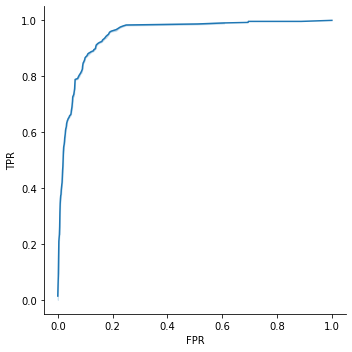

In [69]:
from sklearn.metrics import roc_curve
# ROC
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_validation["product_issue"].values.reshape(-1,1), model1.predict(X_validation).ravel())
sns.relplot(x="FPR", y="TPR", data=pd.DataFrame(np.array([fpr_keras, tpr_keras]).transpose(), columns=["FPR", "TPR"]), kind="line")


# Remarks

The model has a good general performance. We will tag GB dataset to enable further EDA.
Lets proceed by doing a RNN variation to account for word position and see if we have improvements.

Next, we proceed by making a model for each subset (business or product issues) and incrementing with RNNs as well.

In [71]:
from EDA.util import agg_jsonls  # helper function
from pprint import pprint

def load_unique_GB(dataset_folder):
    unique_ids = set()
    reviewsGB = []
    for complaint in agg_jsonls(dataset_folder):
        if "id_review" in complaint and complaint["id_review"] not in unique_ids:
            unique_ids.add(complaint["id_review"])
            reviewsGB.append(complaint)
    return reviewsGB

reviewsGB = load_unique_GB("final_dataset_GB_1704")
print(f"We have a total of {len(reviewsGB)} reviews!")
pprint(reviewsGB[0])

We have a total of 140416 reviews!
{'caption': '',
 'geo_location': {'lat': '-23.5975251', 'long': '-46.6025457'},
 'id_review': 'ChZDSUhNMG9nS0VJQ0FnSUNjemR6YkRREAEaFkNKMExMS0tRQnA3NmhQUzlCWkoyTkE',
 'n_photo_user': 0,
 'n_review_user': 1,
 'rating': 4.0,
 'relative_date': '3 semanas atrás',
 'retrieval_date': '2020-04-15T05:32:36Z',
 'store': 'magazine-luiza',
 'url_user': 'https://www.google.com/maps/contrib/114096832037584768938?hl=pt-BR',
 'username': 'Tiago Leonel Barreto'}


In [90]:
from src.text_formatting import remove_numbers, normalize_text,tokenize
from src.model_inference import get_review_embbedings

def get_tokens_from_GB(dataset):
    def format_text_input(row):
        return f"{remove_numbers(normalize_text(row['caption']))}"
    
    texts = [format_text_input(r) for r in dataset]
    tokens_sq = [tokenize(i) for i in texts]
    return tokens_sq

neg_reviews = [r for r in reviewsGB if r["rating"] <3 and len(r["caption"])>0]
gb_feat_vecs = [get_review_embbedings(token, model) for token in get_tokens_from_GB([r for r in neg_reviews])]
feat_num = gb_feat_vecs[0].shape[0]
indexes = pd.Series(gb_feat_vecs)
indexes = indexes[~indexes.isna()].index

# Remove nans and maintain index order to df
gb_df_feat = pd.DataFrame([i for i in gb_feat_vecs if not isinstance(i, type(np.nan))], columns=[f"feat_{i}" for i in range(feat_num)], index=indexes)


/home/luis/ds4a/notebooks/src/model_inference.py:9: RuntimeWarning: Mean of empty slice.
  try:
/home/luis/anaconda3/envs/un_cuda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [91]:
gb_preds = pd.DataFrame(model1.predict(gb_df_feat), index=indexes)
gb_preds.columns = ["Issue"]
gb_preds.head()


,0
0,0.822335
1,1.000000
2,0.000000
3,0.001313
4,0.000000


In [110]:
# Tag reviews
for idx,r in enumerate(neg_reviews):
    if idx in gb_preds.index:
        r["issue"] = gb_preds.loc[idx].values[0]

In [113]:
# Evaluate model predictions
neg_reviews[0:5]

[{'id_review': 'ChZDSUhNMG9nS0VJQ0FnSURNNXBERUFREAEaFjZwVEFadG8xblgySHZTdEdrMEJlYmc',
  'caption': 'Vende eletros domésticos quebrado.  Comprei um liquidificador com defeito.',
  'relative_date': '3 meses atrás',
  'retrieval_date': '2020-04-15T05:33:14Z',
  'rating': 2.0,
  'username': 'Mercia Oliveira',
  'n_review_user': 39,
  'n_photo_user': 0,
  'url_user': 'https://www.google.com/maps/contrib/107839935361960381477?hl=pt-BR',
  'geo_location': {'lat': '-23.5975251', 'long': '-46.6025457'},
  'store': 'magazine-luiza',
  'issue': 'product_issue'},
 {'id_review': 'ChdDSUhNMG9nS0VJQ0FnSUNNdjhMWHF3RRABGhZ2bHdkUXRxdEJkWjlEMEVlclh5R3FR',
  'caption': 'Som muito alto',
  'relative_date': '4 meses atrás',
  'retrieval_date': '2020-04-15T05:33:21Z',
  'rating': 1.0,
  'username': 'Wendy Castiello',
  'n_review_user': 0,
  'n_photo_user': 0,
  'url_user': 'https://www.google.com/maps/contrib/109623549828345753675?hl=pt-BR',
  'geo_location': {'lat': '-23.5975251', 'long': '-46.6025457'},
  

In [114]:
import json

# Dump our enriched dataset
with open("GB_tagged_bin.jsonl", "w", encoding="utf-8") as js:
    for r in neg_reviews:
        js.write(json.dumps(r) + "\n")


## Adding RNN layer 

We will need to establish a sequence lenght and pad sequences that are lower than seq lenght.

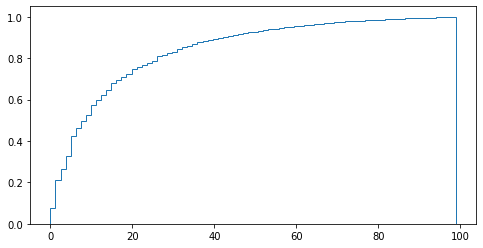

In [124]:
neg_reviews_tokens_len = pd.Series([len(r) for r in get_tokens_from_GB(neg_reviews)])

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist([i for i in neg_reviews_tokens_len if i <100], 80, density=True, histtype='step',cumulative=True, label='Empirical')

Lets set our sequence pad to 25 as a starting point. We re-evaluate it later.

In [135]:
seq = np.zeros([25,model.vector_size])
seq[0,:] = np.ones(100)

In [183]:
from src.text_formatting import get_tokens_from_RA_df

def get_review_embbedings_seq(review_seq, model: "gensim.model", seq_max=25):
    final_seq = np.zeros([seq_max,model.vector_size])
    for i,w in enumerate(review_seq):
        if i<seq_max:
            try:
                final_seq[i,:] = model.wv[w]
            except Exception as err:
                print(err)
    return final_seq

max_seq = 25
# toks = get_tokens_from_GB(neg_reviews)
toks = get_tokens_from_RA_df(df)
feat_seq = np.array([get_review_embbedings_seq(token, model, seq_max=25) for token in toks])

# Sanity check
assert feat_seq.shape == (len(toks), max_seq, model.vector_size)


In [195]:
# Pre-load tag columns
product_issues_columns = ['product_issues_Quality','product_issues_Damaged', 'product_issues_Electrical problems','product_issues_Missing pieces']
business_issues_columns = ['business_issues_Payment','business_issues_Maintenance', 'business_issues_Customer Services','business_issues_Delivery', 'business_issues_Online Services']
tag_columns = product_issues_columns.copy()
tag_columns.extend(business_issues_columns)

# Create product/business issue tag and drop those who have both tagged to simplify our analysis
df_tag = df[tag_columns].fillna(0).applymap(lambda x: 1 if x>0 else 0)
df_tag["product_issue"] = df_tag[product_issues_columns].max(axis=1)
df_tag["business_issue"] = df_tag[business_issues_columns].max(axis=1)

# Added to remove zeroed vectors seqs
df_tag = df_tag.loc[feat_seq.sum(axis=2).sum(axis=1)!=0]
feat_seq = feat_seq[feat_seq.sum(axis=2).sum(axis=1)!=0]

feat_seq = feat_seq[(df_tag[["product_issue", "business_issue"]].sum(axis=1) != 2).values]
df_tag = df_tag[df_tag[["product_issue", "business_issue"]].sum(axis=1) != 2]

feat_seq = feat_seq[(df_tag[["product_issue", "business_issue"]].sum(axis=1) != 0).values]
df_tag = df_tag[df_tag[["product_issue", "business_issue"]].sum(axis=1) != 0]


assert df_tag.shape[0] == feat_seq.shape[0]

In [198]:
from sklearn.model_selection import train_test_split

X = feat_seq
Y = df_tag

X_test = X[-100::]
Y_test = Y.iloc[-100::]

X_t = X[0:-100]
Y_t = Y.iloc[0:-100]

# Sanity check
assert X_test.shape[0] + X_t.shape[0] == X.shape[0]
assert Y_test.shape[0] + Y_t.shape[0] == Y.shape[0]

seed = 2020
split = 0.95  # We have a bunch of data
X_train, X_validation, y_train, y_validation = train_test_split(X_t, Y_t, train_size=split, random_state=seed)

In [209]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Pre-loading
filepath="weights-improvement-SeqModel-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

embedding_dim = 100
batch_size = 128
epochs = 40
stack = 3


def create_RNN(n_dense=6,
               dense_units=16,
               max_seq_len=25,
               lstm_cell=128,
               activation='selu',
               dropout=layers.Dropout,
               dropout_rate=0.1,
               kernel_initializer='lecun_normal',
               optimizer='adam',
               num_classes=1,
               max_words=100):
    
    model = tf.keras.models.Sequential()
    model.add(layers.LSTM(lstm_cell, input_shape=(max_seq_len, max_words)))
    
    for i in range(n_dense - 1):
        model.add(layers.Dense(dense_units//(2+i*2), kernel_initializer=kernel_initializer))
        model.add(layers.Activation(activation))
        model.add(dropout(dropout_rate))

    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


network1 = {
    'n_dense': stack,
    "lstm_cell": 64,
    'dense_units': 64,
    'activation': 'relu',
    'dropout': layers.Dropout,
    'dropout_rate': 0.5,
    "max_words": embedding_dim,
    'kernel_initializer': 'glorot_uniform',
    'optimizer': 'adam'
}

model_rnn = create_RNN(num_classes=num_classes, **network1)
model_rnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_49 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_49 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_50 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 32)              

In [210]:
history_model1 = model_rnn.fit(X_train,
                            y_train["product_issue"].values.reshape(-1,1),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            callbacks=callbacks_list,
                            validation_data=(X_validation, y_validation["product_issue"].values.reshape(-1,1)))

Train on 24671 samples, validate on 1299 samples
Epoch 1/40
24448/24671 [============================>.] - ETA: 0s - loss: 0.4462 - acc: 0.7926
Epoch 00001: val_loss improved from -inf to 0.31611, saving model to weights-improvement-SeqModel-01-0.32.hdf5
24671/24671 [==============================] - 8s 335us/sample - loss: 0.4451 - acc: 0.7928 - val_loss: 0.3161 - val_acc: 0.8630
Epoch 2/40
24448/24671 [============================>.] - ETA: 0s - loss: 0.3092 - acc: 0.8662
Epoch 00002: val_loss did not improve from 0.31611
24671/24671 [==============================] - 7s 286us/sample - loss: 0.3088 - acc: 0.8665 - val_loss: 0.2614 - val_acc: 0.8845
Epoch 3/40
24448/24671 [============================>.] - ETA: 0s - loss: 0.2654 - acc: 0.8905
Epoch 00003: val_loss did not improve from 0.31611
24671/24671 [==============================] - 7s 287us/sample - loss: 0.2650 - acc: 0.8908 - val_loss: 0.2415 - val_acc: 0.8984
Epoch 4/40
24448/24671 [============================>.] - ETA: 0s 

In [217]:



def create_BiRNN(n_dense=6,
                   dense_units=16,
                   max_seq_len=25,
                   lstm_cell=128,
                   activation='selu',
                   dropout=layers.Dropout,
                   dropout_rate=0.1,
                   bi_merge="concat",
                   kernel_initializer='lecun_normal',
                   optimizer='adam',
                   num_classes=1,
                   max_words=100):
    
    model = tf.keras.models.Sequential()
    model.add(layers.Bidirectional(layers.LSTM(lstm_cell), input_shape=(max_seq_len, max_words) , merge_mode=bi_merge))
    
    for i in range(n_dense - 1):
        model.add(layers.Dense(dense_units//(2+i*2), kernel_initializer=kernel_initializer))
        model.add(layers.Activation(activation))
        model.add(dropout(dropout_rate))

    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

network3 = {
    'n_dense': stack,
    "lstm_cell": 64,
    'dense_units': 64,
    'activation': 'relu',
    "bi_merge": "concat",
    'dropout': layers.Dropout,
    'dropout_rate': 0.5,
    "max_words": embedding_dim,
    'kernel_initializer': 'glorot_uniform',
    'optimizer': 'adam'
}

model_rnn2 = create_BiRNN(num_classes=num_classes, **network3)
model_rnn2.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_61 (Dense)             (None, 32)                4128      
_________________________________________________________________
activation_61 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 16)                528       
_________________________________________________________________
activation_62 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 16)              

In [218]:

# Pre-loading
filepath="weights-improvement-SeqModelBi-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_model_rnn_2 = model_rnn2.fit(X_train,
                            y_train["product_issue"].values.reshape(-1,1),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            callbacks=callbacks_list,
                            validation_data=(X_validation, y_validation["product_issue"].values.reshape(-1,1)))

Train on 24671 samples, validate on 1299 samples
Epoch 1/40
24576/24671 [============================>.] - ETA: 0s - loss: 0.4540 - acc: 0.7852
Epoch 00001: val_acc improved from -inf to 0.88068, saving model to weights-improvement-SeqModelBi-01-0.88.hdf5
24671/24671 [==============================] - 13s 534us/sample - loss: 0.4537 - acc: 0.7853 - val_loss: 0.2767 - val_acc: 0.8807
Epoch 2/40
24576/24671 [============================>.] - ETA: 0s - loss: 0.3094 - acc: 0.8769
Epoch 00002: val_acc improved from 0.88068 to 0.88761, saving model to weights-improvement-SeqModelBi-02-0.89.hdf5
24671/24671 [==============================] - 11s 452us/sample - loss: 0.3089 - acc: 0.8770 - val_loss: 0.2520 - val_acc: 0.8876
Epoch 3/40
24576/24671 [============================>.] - ETA: 0s - loss: 0.2698 - acc: 0.8906
Epoch 00003: val_acc improved from 0.88761 to 0.89222, saving model to weights-improvement-SeqModelBi-03-0.89.hdf5
24671/24671 [==============================] - 11s 454us/sample 

### Remarks

Using recurrent networks did not improve our model accuracy. Lets double the sequence size and check how it performs with more spatial information.

In [220]:
# Recomputing data preprocessing with seq=50...

from src.text_formatting import get_tokens_from_RA_df

def get_review_embbedings_seq(review_seq, model: "gensim.model", seq_max=25):
    final_seq = np.zeros([seq_max,model.vector_size])
    for i,w in enumerate(review_seq):
        if i<seq_max:
            try:
                final_seq[i,:] = model.wv[w]
            except Exception as err:
                print(err)
    return final_seq

max_seq = 50
toks = get_tokens_from_RA_df(df)
feat_seq = np.array([get_review_embbedings_seq(token, model, seq_max=max_seq) for token in toks])

# Sanity check
assert feat_seq.shape == (len(toks), max_seq, model.vector_size)

# Pre-load tag columns
product_issues_columns = ['product_issues_Quality','product_issues_Damaged', 'product_issues_Electrical problems','product_issues_Missing pieces']
business_issues_columns = ['business_issues_Payment','business_issues_Maintenance', 'business_issues_Customer Services','business_issues_Delivery', 'business_issues_Online Services']
tag_columns = product_issues_columns.copy()
tag_columns.extend(business_issues_columns)

# Create product/business issue tag and drop those who have both tagged to simplify our analysis
df_tag = df[tag_columns].fillna(0).applymap(lambda x: 1 if x>0 else 0)
df_tag["product_issue"] = df_tag[product_issues_columns].max(axis=1)
df_tag["business_issue"] = df_tag[business_issues_columns].max(axis=1)

# Added to remove zeroed vectors seqs
df_tag = df_tag.loc[feat_seq.sum(axis=2).sum(axis=1)!=0]
feat_seq = feat_seq[feat_seq.sum(axis=2).sum(axis=1)!=0]

feat_seq = feat_seq[(df_tag[["product_issue", "business_issue"]].sum(axis=1) != 2).values]
df_tag = df_tag[df_tag[["product_issue", "business_issue"]].sum(axis=1) != 2]

feat_seq = feat_seq[(df_tag[["product_issue", "business_issue"]].sum(axis=1) != 0).values]
df_tag = df_tag[df_tag[["product_issue", "business_issue"]].sum(axis=1) != 0]


assert df_tag.shape[0] == feat_seq.shape[0]


from sklearn.model_selection import train_test_split

X = feat_seq
Y = df_tag

X_test = X[-100::]
Y_test = Y.iloc[-100::]

X_t = X[0:-100]
Y_t = Y.iloc[0:-100]

# Sanity check
assert X_test.shape[0] + X_t.shape[0] == X.shape[0]
assert Y_test.shape[0] + Y_t.shape[0] == Y.shape[0]

seed = 2020
split = 0.95  # We have a bunch of data
X_train, X_validation, y_train, y_validation = train_test_split(X_t, Y_t, train_size=split, random_state=seed)


In [226]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Pre-loading
filepath="weights-improvement-SeqModel50-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

embedding_dim = 100
batch_size = 128
epochs = 40
stack = 3


def create_RNN(n_dense=6,
               dense_units=16,
               max_seq_len=25,
               lstm_cell=128,
               activation='selu',
               dropout=layers.Dropout,
               dropout_rate=0.1,
               kernel_initializer='lecun_normal',
               optimizer='adam',
               num_classes=1,
               max_words=100):
    
    model = tf.keras.models.Sequential()
    model.add(layers.LSTM(lstm_cell, input_shape=(max_seq_len, max_words)))
    
    for i in range(n_dense - 1):
        model.add(layers.Dense(dense_units//(2+i*2), kernel_initializer=kernel_initializer))
        model.add(layers.Activation(activation))
        model.add(dropout(dropout_rate))

    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


network1 = {
    'n_dense': stack,
    "lstm_cell": 64,
    'dense_units': 64,
    "max_seq_len":max_seq,
    'activation': 'relu',
    'dropout': layers.Dropout,
    'dropout_rate': 0.5,
    "max_words": embedding_dim,
    'kernel_initializer': 'glorot_uniform',
    'optimizer': 'adam'
}

model_rnn = create_RNN(num_classes=num_classes, **network1)
model_rnn.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_76 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_76 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 16)                528       
_________________________________________________________________
activation_77 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 16)              

In [227]:
history_model1 = model_rnn.fit(X_train,
                            y_train["product_issue"].values.reshape(-1,1),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            callbacks=callbacks_list,
                            validation_data=(X_validation, y_validation["product_issue"].values.reshape(-1,1)))

Train on 24671 samples, validate on 1299 samples
Epoch 1/40
24576/24671 [============================>.] - ETA: 0s - loss: 0.5472 - acc: 0.7664
Epoch 00001: val_acc improved from -inf to 0.79061, saving model to weights-improvement-SeqModel50-01-0.79.hdf5
24671/24671 [==============================] - 14s 585us/sample - loss: 0.5472 - acc: 0.7664 - val_loss: 0.4620 - val_acc: 0.7906
Epoch 2/40
24576/24671 [============================>.] - ETA: 0s - loss: 0.4616 - acc: 0.7898
Epoch 00002: val_acc improved from 0.79061 to 0.80600, saving model to weights-improvement-SeqModel50-02-0.81.hdf5
24671/24671 [==============================] - 12s 497us/sample - loss: 0.4615 - acc: 0.7899 - val_loss: 0.3882 - val_acc: 0.8060
Epoch 3/40
24576/24671 [============================>.] - ETA: 0s - loss: 0.3812 - acc: 0.8096
Epoch 00003: val_acc improved from 0.80600 to 0.84604, saving model to weights-improvement-SeqModel50-03-0.85.hdf5
24671/24671 [==============================] - 12s 502us/sample 

## Remarks

Yep, no improvements. Increasing seq size created more noise. Well, lets see if we can get gains when infering multiple categories.


# Micro categories models 

Now we focus on trying to tag micro categories for each macro issue.

In [228]:
tag_columns

['product_issues_Quality',
 'product_issues_Damaged',
 'product_issues_Electrical problems',
 'product_issues_Missing pieces',
 'business_issues_Payment',
 'business_issues_Maintenance',
 'business_issues_Customer Services',
 'business_issues_Delivery',
 'business_issues_Online Services']

In [230]:
len(y_train[tag_columns].columns)

9

In [235]:

# Pre-loading
filepath="weights-improvement-SeqModel50MultiTag-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

embedding_dim = 100
batch_size = 128
epochs = 40
stack = 3


def create_RNN(n_dense=6,
               dense_units=16,
               max_seq_len=25,
               lstm_cell=128,
               activation='selu',
               dropout=layers.Dropout,
               dropout_rate=0.1,
               kernel_initializer='lecun_normal',
               optimizer='adam',
               num_classes=1,
               max_words=100):
    
    model = tf.keras.models.Sequential()
    model.add(layers.LSTM(lstm_cell, input_shape=(max_seq_len, max_words)))
    
    for i in range(n_dense - 1):
        model.add(layers.Dense(dense_units//(2+i*2), kernel_initializer=kernel_initializer))
        model.add(layers.Activation(activation))
        model.add(dropout(dropout_rate))

    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('sigmoid'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


network1 = {
    'n_dense': stack,
    "lstm_cell": 256,
    'dense_units': 128,
    "max_seq_len":max_seq,
    'activation': 'selu',
    'dropout': layers.Dropout,
    'dropout_rate': 0.5,
    "max_words": embedding_dim,
    'kernel_initializer': 'glorot_uniform',
    'optimizer': 'adam'
}

num_classes = len(y_train[tag_columns].columns)

model_rnn = create_RNN(num_classes=num_classes, **network1)
model_rnn.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 256)               365568    
_________________________________________________________________
dense_91 (Dense)             (None, 64)                16448     
_________________________________________________________________
activation_91 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_92 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 32)              

In [236]:
history_model1 = model_rnn.fit(X_train,
                            y_train[tag_columns],
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            callbacks=callbacks_list,
                            validation_data=(X_validation, y_validation[tag_columns]))

Train on 24671 samples, validate on 1299 samples
Epoch 1/40
24576/24671 [============================>.] - ETA: 0s - loss: 1.8090 - acc: 0.4437
Epoch 00001: val_acc improved from -inf to 0.51116, saving model to weights-improvement-SeqModel50MultiTag-01-0.51.hdf5
24671/24671 [==============================] - 15s 588us/sample - loss: 1.8075 - acc: 0.4439 - val_loss: 1.3380 - val_acc: 0.5112
Epoch 2/40
24576/24671 [============================>.] - ETA: 0s - loss: 1.4106 - acc: 0.5279
Epoch 00002: val_acc improved from 0.51116 to 0.52040, saving model to weights-improvement-SeqModel50MultiTag-02-0.52.hdf5
24671/24671 [==============================] - 12s 497us/sample - loss: 1.4105 - acc: 0.5279 - val_loss: 1.2685 - val_acc: 0.5204
Epoch 3/40
24576/24671 [============================>.] - ETA: 0s - loss: 1.3034 - acc: 0.5626
Epoch 00003: val_acc improved from 0.52040 to 0.56120, saving model to weights-improvement-SeqModel50MultiTag-03-0.56.hdf5
24671/24671 [===========================

## Remarks

Well, nice improvement from our previous iteration.

Lets break, into simpler two models. Lets see if we have a reasonable improvement.

In [238]:

# Pre-loading
filepath="weights-improvement-SeqModel50MultiTag-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

embedding_dim = 100
batch_size = 128
epochs = 40
stack = 3


def create_RNN(n_dense=6,
               dense_units=16,
               max_seq_len=25,
               lstm_cell=128,
               activation='selu',
               dropout=layers.Dropout,
               dropout_rate=0.1,
               kernel_initializer='lecun_normal',
               optimizer='adam',
               num_classes=1,
               max_words=100):
    
    model = tf.keras.models.Sequential()
    model.add(layers.LSTM(lstm_cell, input_shape=(max_seq_len, max_words)))
    
    for i in range(n_dense - 1):
        model.add(layers.Dense(dense_units//(2+i*2), kernel_initializer=kernel_initializer))
        model.add(layers.Activation(activation))
        model.add(dropout(dropout_rate))

    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('sigmoid'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


network1 = {
    'n_dense': stack,
    "lstm_cell": 128,
    'dense_units': 64,
    "max_seq_len":max_seq,
    'activation': 'selu',
    'dropout': layers.Dropout,
    'dropout_rate': 0.5,
    "max_words": embedding_dim,
    'kernel_initializer': 'glorot_uniform',
    'optimizer': 'adam'
}

num_classes = len(y_train[product_issues_columns].columns)

model_rnn_prod_tags = create_RNN(num_classes=num_classes, **network1)
model_rnn_prod_tags.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_94 (Dense)             (None, 32)                4128      
_________________________________________________________________
activation_94 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_95 (Dense)             (None, 16)                528       
_________________________________________________________________
activation_95 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 16)              

In [239]:
history_model1 = model_rnn_prod_tags.fit(X_train,
                            y_train[product_issues_columns],
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            callbacks=callbacks_list,
                            validation_data=(X_validation, y_validation[product_issues_columns]))

Train on 24671 samples, validate on 1299 samples
Epoch 1/40
24576/24671 [============================>.] - ETA: 0s - loss: 0.2450 - acc: 0.6028
Epoch 00001: val_acc improved from -inf to 0.91455, saving model to weights-improvement-SeqModel50MultiTag-01-0.91.hdf5
24671/24671 [==============================] - 15s 613us/sample - loss: 0.2449 - acc: 0.6034 - val_loss: 0.2013 - val_acc: 0.9145
Epoch 2/40
24576/24671 [============================>.] - ETA: 0s - loss: 0.2170 - acc: 0.7950
Epoch 00002: val_acc improved from 0.91455 to 0.91686, saving model to weights-improvement-SeqModel50MultiTag-02-0.92.hdf5
24671/24671 [==============================] - 12s 505us/sample - loss: 0.2169 - acc: 0.7949 - val_loss: 0.1970 - val_acc: 0.9169
Epoch 3/40
24576/24671 [============================>.] - ETA: 0s - loss: 0.2081 - acc: 0.8606
Epoch 00003: val_acc did not improve from 0.91686
24671/24671 [==============================] - 13s 512us/sample - loss: 0.2088 - acc: 0.8606 - val_loss: 0.1969 -

### Business issue tags



In [240]:

# Pre-loading
filepath="weights-improvement-SeqModel50MultiTagBusiness-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

embedding_dim = 100
batch_size = 128
epochs = 20
stack = 3


def create_RNN(n_dense=6,
               dense_units=16,
               max_seq_len=25,
               lstm_cell=128,
               activation='selu',
               dropout=layers.Dropout,
               dropout_rate=0.1,
               kernel_initializer='lecun_normal',
               optimizer='adam',
               num_classes=1,
               max_words=100):
    
    model = tf.keras.models.Sequential()
    model.add(layers.LSTM(lstm_cell, input_shape=(max_seq_len, max_words)))
    
    for i in range(n_dense - 1):
        model.add(layers.Dense(dense_units//(2+i*2), kernel_initializer=kernel_initializer))
        model.add(layers.Activation(activation))
        model.add(dropout(dropout_rate))

    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('sigmoid'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


network2 = {
    'n_dense': stack,
    "lstm_cell": 128,
    'dense_units': 64,
    "max_seq_len":max_seq,
    'activation': 'selu',
    'dropout': layers.Dropout,
    'dropout_rate': 0.5,
    "max_words": embedding_dim,
    'kernel_initializer': 'glorot_uniform',
    'optimizer': 'adam'
}

num_classes = len(y_train[business_issues_columns].columns)

model_rnn_business_tags = create_RNN(num_classes=num_classes, **network2)
model_rnn_business_tags.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_97 (Dense)             (None, 32)                4128      
_________________________________________________________________
activation_97 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 16)                528       
_________________________________________________________________
activation_98 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 16)              

In [241]:
history_model2 = model_rnn_business_tags.fit(X_train,
                            y_train[business_issues_columns],
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            callbacks=callbacks_list,
                            validation_data=(X_validation, y_validation[business_issues_columns]))

Train on 24671 samples, validate on 1299 samples
Epoch 1/20
24576/24671 [============================>.] - ETA: 0s - loss: 1.0519 - acc: 0.4460
Epoch 00001: val_acc improved from -inf to 0.45958, saving model to weights-improvement-SeqModel50MultiTagBusiness-01-0.46.hdf5
24671/24671 [==============================] - 15s 621us/sample - loss: 1.0515 - acc: 0.4458 - val_loss: 0.9036 - val_acc: 0.4596
Epoch 2/20
24576/24671 [============================>.] - ETA: 0s - loss: 0.9076 - acc: 0.4926
Epoch 00002: val_acc improved from 0.45958 to 0.47421, saving model to weights-improvement-SeqModel50MultiTagBusiness-02-0.47.hdf5
24671/24671 [==============================] - 12s 495us/sample - loss: 0.9070 - acc: 0.4928 - val_loss: 0.7965 - val_acc: 0.4742
Epoch 3/20
24576/24671 [============================>.] - ETA: 0s - loss: 0.8301 - acc: 0.5087
Epoch 00003: val_acc improved from 0.47421 to 0.50500, saving model to weights-improvement-SeqModel50MultiTagBusiness-03-0.51.hdf5
24671/24671 [===

## Remarks
yeah, classification for business issues is harder than for product issues.

Breaking them was helpful.

# Taggging Negative reviews from GB

We will use the previous tagged reviews and enrich them using our models predictions!

In [242]:
def get_review_embbedings_seq(review_seq, model: "gensim.model", seq_max=25):
    final_seq = np.zeros([seq_max,model.vector_size])
    for i,w in enumerate(review_seq):
        if i<seq_max:
            try:
                final_seq[i,:] = model.wv[w]
            except Exception as err:
                print(err)
    return final_seq

max_seq = 50
toks = get_tokens_from_GB(neg_reviews)  # Now using neg reviews from GB!
feat_seq_GB = np.array([get_review_embbedings_seq(token, model, seq_max=max_seq) for token in toks])

# Sanity check
assert feat_seq_GB.shape == (len(toks), max_seq, model.vector_size)




In [246]:
neg_reviews[0]

{'id_review': 'ChZDSUhNMG9nS0VJQ0FnSURNNXBERUFREAEaFjZwVEFadG8xblgySHZTdEdrMEJlYmc',
 'caption': 'Vende eletros domésticos quebrado.  Comprei um liquidificador com defeito.',
 'relative_date': '3 meses atrás',
 'retrieval_date': '2020-04-15T05:33:14Z',
 'rating': 2.0,
 'username': 'Mercia Oliveira',
 'n_review_user': 39,
 'n_photo_user': 0,
 'url_user': 'https://www.google.com/maps/contrib/107839935361960381477?hl=pt-BR',
 'geo_location': {'lat': '-23.5975251', 'long': '-46.6025457'},
 'store': 'magazine-luiza',
 'issue': 'product_issue'}

In [279]:

for review, feat_seq in zip(neg_reviews, feat_seq_GB):
    if "issue" in review:
        if review["issue"] == "product_issue":
            pred = model_rnn_prod_tags.predict(np.expand_dims(feat_seq, axis=0))
            tags = np.array(product_issues_columns)[(np.round(pred)==1)[0]]
            review["tags"] = list(tags)
        else:
            pred = model_rnn_business_tags.predict(np.expand_dims(feat_seq, axis=0))
            tags = np.array(business_issues_columns)[(np.round(pred)==1)[0]]
            review["tags"] = list(tags)


In [284]:
neg_reviews[0]

{'id_review': 'ChZDSUhNMG9nS0VJQ0FnSURNNXBERUFREAEaFjZwVEFadG8xblgySHZTdEdrMEJlYmc',
 'caption': 'Vende eletros domésticos quebrado.  Comprei um liquidificador com defeito.',
 'relative_date': '3 meses atrás',
 'retrieval_date': '2020-04-15T05:33:14Z',
 'rating': 2.0,
 'username': 'Mercia Oliveira',
 'n_review_user': 39,
 'n_photo_user': 0,
 'url_user': 'https://www.google.com/maps/contrib/107839935361960381477?hl=pt-BR',
 'geo_location': {'lat': '-23.5975251', 'long': '-46.6025457'},
 'store': 'magazine-luiza',
 'issue': 'product_issue',
 'tags': ['product_issues_Quality', 'product_issues_Damaged']}

In [287]:
i = 0
for r in neg_reviews:
    if len(r["caption"]) > 20:
        pprint(r)
        i+=1
    if i ==10:
        break
    

{'caption': 'Vende eletros domésticos quebrado.  Comprei um liquidificador com '
            'defeito.',
 'geo_location': {'lat': '-23.5975251', 'long': '-46.6025457'},
 'id_review': 'ChZDSUhNMG9nS0VJQ0FnSURNNXBERUFREAEaFjZwVEFadG8xblgySHZTdEdrMEJlYmc',
 'issue': 'product_issue',
 'n_photo_user': 0,
 'n_review_user': 39,
 'rating': 2.0,
 'relative_date': '3 meses atrás',
 'retrieval_date': '2020-04-15T05:33:14Z',
 'store': 'magazine-luiza',
 'tags': ['product_issues_Quality', 'product_issues_Damaged'],
 'url_user': 'https://www.google.com/maps/contrib/107839935361960381477?hl=pt-BR',
 'username': 'Mercia Oliveira'}
{'caption': 'Péssimo atendimento e não tem telefone para atender os clientes '
            'tem que ir na loja minha primeira compra e última não dão '
            'satisfação da entrega pqp',
 'geo_location': {'lat': '-23.5975251', 'long': '-46.6025457'},
 'id_review': 'ChZDSUhNMG9nS0VJQ0FnSUNNdDVidE5nEAEaFmE3R1pMTGtPdmJIUU9tQXYxd2xqVGc',
 'issue': 'business_issue',
 'n_pho

In [282]:
import json
with open("GB_tagged_final-0501.jsonl", "w", encoding="utf-8") as js:
    for r in neg_reviews:
        js.write(json.dumps(r) + "\n")
